### Cadenas Usando LangGraph
En esta sección veremos cómo podemos construir una cadena simple usando Langgraph que utiliza 4 conceptos importantes:

- Cómo usar mensajes de chat como nuestro estado del grafo
- Cómo usar modelos de chat en nodos del grafo
- Cómo vincular herramientas a nuestro LLM en modelos de chat
- Cómo ejecutar las llamadas a herramientas en nuestros nodos del grafo

In [1]:
# Importamos load_dotenv para cargar variables de entorno desde .env
from dotenv import load_dotenv
# Cargamos las variables de entorno
load_dotenv()

# Importamos os para gestionar variables de entorno
import os
# Configuramos la API key de OpenAI desde las variables de entorno
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
# Configuramos la API key de GROQ desde las variables de entorno
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### Cómo usar mensajes de chat como nuestro estado del grafo
##### Mensajes

Podemos usar mensajes que pueden capturar diferentes roles dentro de una conversación.
LangChain tiene varios tipos de mensajes incluyendo HumanMessage, AIMessage, SystemMessage y ToolMessage.
Estos representan un mensaje del usuario, del modelo de chat, para que el modelo de chat instrucciones de comportamiento, y de una llamada a herramienta.

Cada mensaje tiene estos componentes importantes:

- content - contenido del mensaje
- name - Especificar el nombre del autor
- response_metadata - opcionalmente, un diccionario de metadatos (por ejemplo, a menudo poblado por el proveedor del modelo para AIMessages)



In [3]:
# Importamos AIMessage y HumanMessage para crear diferentes tipos de mensajes
from langchain_core.messages import AIMessage,HumanMessage
# Importamos pprint para imprimir de forma más legible
from pprint import pprint

# Creamos una lista de mensajes comenzando con un mensaje del modelo AI
messages=[AIMessage(content=f"Por favor dime cómo puedo ayudarte",name="ModeloLLM")]
# Agregamos un mensaje humano a la conversación
messages.append(HumanMessage(content=f"Quiero aprender a programar",name="Raul"))
# Agregamos otra respuesta del modelo AI
messages.append(AIMessage(content=f"¿Qué lenguaje de programación quieres aprender?",name="ModeloLLM"))
# Agregamos otra pregunta del humano
messages.append(HumanMessage(content=f"Quiero aprender el lenguaje de programación Python",name="Raul"))

# Iteramos sobre todos los mensajes y los imprimimos de forma bonita
for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: ModeloLLM

Por favor dime cómo puedo ayudarte
================================ Human Message =================================
Name: Raul

Quiero aprender a programar
================================== Ai Message ==================================
Name: ModeloLLM

¿Qué lenguaje de programación quieres aprender?
================================ Human Message =================================
Name: Raul

Quiero aprender el lenguaje de programación Python


### Modelos de Chat

Podemos usar la secuencia de mensajes como entrada con los modelos de chat usando LLM's y OPENAI.

In [4]:
# Importamos ChatGroq para usar el modelo de chat de Groq
from langchain_groq import ChatGroq
# Inicializamos el modelo de lenguaje con el modelo llama-3.1-8b-instant
llm=ChatGroq(model="llama-3.1-8b-instant")
# Invocamos el modelo con la lista completa de mensajes
# El modelo procesará toda la conversación y generará una respuesta
result=llm.invoke(messages)

c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Accedemos a los metadatos de la respuesta
# Esto incluye información sobre el uso de tokens, tiempo de procesamiento, etc.
result.response_metadata

{'token_usage': {'completion_tokens': 479,
  'prompt_tokens': 85,
  'total_tokens': 564,
  'completion_time': 0.768095814,
  'prompt_time': 0.007119703,
  'queue_time': 0.230247229,
  'total_time': 0.775215517},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_ab04adca7d',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Herramientas
Las herramientas pueden integrarse con los modelos LLM para interactuar con sistemas externos. Los sistemas externos pueden ser API's, herramientas de terceros.

Cuando se hace una consulta, el modelo puede elegir llamar a la herramienta y esta consulta se basa en la 
entrada de lenguaje natural y esto devolverá una salida que coincide con el esquema de la herramienta

In [7]:
# Definimos una función simple que suma dos números
def add(a:int,b:int)-> int:
    """ Suma a y b
    Args:
        a (int): primer entero
        b (int): segundo entero

    Returns:
        int: la suma de a y b
    """
    # Retornamos la suma de los dos números
    return a+b

In [8]:
# Inspeccionamos el objeto llm para ver su configuración
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F7015D3B30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F7017FBAD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
### Vinculando herramienta con llm

# Vinculamos la herramienta 'add' al modelo de lenguaje
# Esto permite que el LLM sepa que puede usar esta función
llm_with_tools=llm.bind_tools([add])

# Invocamos el LLM con una pregunta matemática
# El modelo detectará que necesita usar la herramienta 'add'
tool_call=llm_with_tools.invoke([HumanMessage(content=f"¿Cuánto es 2 más 2?",name="Raul")])

In [13]:
# Verificamos las llamadas a herramientas que el modelo decidió hacer
# Aquí veremos que el modelo llamó a 'add' con los argumentos a=2 y b=2
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'akw0nky1t',
  'type': 'tool_call'}]

### Usando mensajes como estado

In [14]:
# Importamos TypedDict para definir la estructura del estado
from typing_extensions import TypedDict
# Importamos AnyMessage que puede ser cualquier tipo de mensaje
from langchain_core.messages import AnyMessage

# Definimos la clase State con un campo 'message' que es una lista de mensajes
class State(TypedDict):
    message:list[AnyMessage]

#### Reductores
¡Ahora, tenemos un problema menor!

Como discutimos, cada nodo devolverá un nuevo valor para nuestra clave de estado messages.

Pero, este nuevo valor sobrescribirá el valor anterior de messages.

A medida que se ejecuta nuestro grafo, queremos agregar mensajes a nuestra clave de estado messages.

Podemos usar funciones reductoras para abordar esto.

Los reductores nos permiten especificar cómo se realizan las actualizaciones de estado.

Si no se especifica una función reductora, entonces se asume que las actualizaciones a la clave deben sobrescribirla como vimos antes.

Pero, para agregar mensajes, podemos usar el reductor precompilado add_messages.

Esto asegura que cualquier mensaje se agregue a la lista existente de mensajes.

Simplemente necesitamos anotar nuestra clave messages con la función reductora add_messages como metadato.

In [15]:
# Importamos add_messages, el reductor precompilado para agregar mensajes
from langgraph.graph.message import add_messages
# Importamos Annotated para agregar metadatos a los tipos
from typing import Annotated
# Redefinimos State con el reductor add_messages
class State(TypedDict):
    # Anotamos messages con add_messages para que los mensajes se agreguen en lugar de sobrescribirse
    messages:Annotated[list[AnyMessage],add_messages]

### Reductores con add_messages

In [16]:
# Creamos una lista inicial de mensajes
initial_messages=[AIMessage(content=f"Por favor dime cómo puedo ayudarte",name="ModeloLLM")]
# Agregamos un mensaje humano
initial_messages.append(HumanMessage(content=f"Quiero aprender a programar",name="Raul"))
# Mostramos los mensajes iniciales
initial_messages

[AIMessage(content='Por favor dime cómo puedo ayudarte', additional_kwargs={}, response_metadata={}, name='ModeloLLM'),
 HumanMessage(content='Quiero aprender a programar', additional_kwargs={}, response_metadata={}, name='Raul')]

In [17]:
# Creamos un nuevo mensaje AI que queremos agregar
ai_message=AIMessage(content=f"¿Qué lenguaje de programación quieres aprender?",name="ModeloLLM")
# Mostramos el mensaje
ai_message

AIMessage(content='¿Qué lenguaje de programación quieres aprender?', additional_kwargs={}, response_metadata={}, name='ModeloLLM')

In [18]:
# El reductor add_messages agrega mensajes en lugar de sobrescribirlos
# Aquí combinamos initial_messages con ai_message
# El resultado será una lista con todos los mensajes combinados
add_messages(initial_messages,ai_message)

[AIMessage(content='Por favor dime cómo puedo ayudarte', additional_kwargs={}, response_metadata={}, name='ModeloLLM', id='7ae0d5f1-e208-4e21-bfbc-7276d304f11a'),
 HumanMessage(content='Quiero aprender a programar', additional_kwargs={}, response_metadata={}, name='Raul', id='67387a30-57f3-4d02-9918-06939d3c64e6'),
 AIMessage(content='¿Qué lenguaje de programación quieres aprender?', additional_kwargs={}, response_metadata={}, name='ModeloLLM', id='2e58f59c-412a-45c5-8555-addff6e9d9a1')]

In [19]:
# Definimos la funcionalidad del nodo del chatbot
def llm_tool(state:State):
    # Invocamos el LLM con herramientas usando los mensajes del estado
    # Retornamos un diccionario con los nuevos mensajes que se agregarán al estado
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

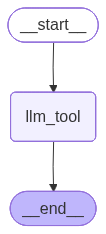

In [20]:
# Importamos Image y display para visualizar el grafo
from IPython.display import Image, display
# Importamos los componentes de LangGraph
from langgraph.graph import StateGraph, START, END
# Creamos el constructor del grafo con el estado definido
builder=StateGraph(State)

# Agregamos el nodo "llm_tool" que ejecuta la función llm_tool
builder.add_node("llm_tool",llm_tool)

# Conectamos START al nodo "llm_tool"
builder.add_edge(START,"llm_tool")
# Conectamos "llm_tool" al nodo END
builder.add_edge("llm_tool",END)

# Compilamos el grafo
graph=builder.compile()

# Mostramos el diagrama del grafo
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Invocación del grafo

# Invocamos el grafo con una pregunta matemática
messages=graph.invoke({"messages":"¿Cuánto es 2 más 2?"})

# Iteramos sobre todos los mensajes resultantes y los imprimimos
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

¿Cuánto es 2 más 2?
================================== Ai Message ==================================
Tool Calls:
  add (xqtjqz0rm)
 Call ID: xqtjqz0rm
  Args:
    a: 2
    b: 2


In [22]:
# Definimos una lista de herramientas disponibles
# En este caso solo tenemos la función 'add'
tools=[add]

In [23]:
# Importamos ToolNode para crear un nodo que ejecuta herramientas
from langgraph.prebuilt import ToolNode
# Importamos tools_condition para enrutar condicionalmente según si hay llamadas a herramientas
from langgraph.prebuilt import tools_condition

# Creamos un nuevo constructor del grafo
builder=StateGraph(State)

## Agregamos nodos

# Agregamos el nodo "llm_tool" que llama al LLM con herramientas
builder.add_node("llm_tool",llm_tool)
# Agregamos el nodo "tools" que ejecuta las herramientas llamadas
builder.add_node("tools",ToolNode(tools))

## Agregamos Aristas
# Conectamos START al nodo "llm_tool"
builder.add_edge(START,"llm_tool")
# Agregamos aristas condicionales desde "llm_tool"
builder.add_conditional_edges(
    "llm_tool",
    # Si el último mensaje (resultado) del asistente es una llamada a herramienta -> tools_condition enruta a tools
    # Si el último mensaje (resultado) del asistente NO es una llamada a herramienta -> tools_condition enruta a END
    tools_condition
)
# Conectamos "tools" a END después de ejecutar la herramienta
builder.add_edge("tools",END)

# Compilamos el grafo
graph_builder = builder.compile()



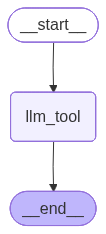

In [24]:
# Mostramos el diagrama del grafo con enrutamiento condicional
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# Invocación del grafo con ejecución de herramientas

# Invocamos el grafo con una pregunta matemática
messages=graph.invoke({"messages":"¿Cuánto es 2 más 2?"})

# Iteramos sobre todos los mensajes (pregunta, llamada a herramienta y resultado)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

¿Cuánto es 2 más 2?
================================== Ai Message ==================================
Tool Calls:
  add (vz9e7yx30)
 Call ID: vz9e7yx30
  Args:
    a: 2
    b: 2


In [26]:
# Invocamos el grafo con una pregunta que NO requiere herramientas
# El modelo responderá directamente sin llamar a la herramienta 'add'
messages=graph.invoke({"messages":"¿Qué es Machine Learning?"})

# Iteramos sobre los mensajes de la conversación
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

¿Qué es Machine Learning?
================================== Ai Message ==================================

<brave_search> Machine Learning
